# Import Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Load The Dataset

We work only on Lung Cancer so we laod the dataset that are belong to lung cancer

In [2]:
# Path to the main dataset directory
dataset_dir = '/kaggle/input/lung-and-colon-cancer/Lung_and_Colon_Cancer'

# Dictionary to store the count of samples per class
class_counts = {}

# Updated dictionary with exact class names related to lung cancer
class_nms = {
    'Lung_Adenocarcinoma': 'LACA',
    'Lung-Benign_Tissue': 'LN',
    'Lung_Squamous_Cell_Carcinoma': 'LSCC'
}

# Dictionary to store exact class names found in the dataset
exact_class_names = {}

# Calculate the number of samples in each lung cancer-related class
total_samples = 0
for cls in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_dir) and cls in class_nms:
        class_abbr = class_nms[cls]
        count = len(os.listdir(class_dir))
        class_counts[class_abbr] = count
        total_samples += count
        exact_class_names[class_abbr] = cls  # Store the exact class name

# Print the total number of samples
print(f"Total number of samples in the dataset: {total_samples}")
print(exact_class_names)

Total number of samples in the dataset: 15000

{'LACA': 'Lung_Adenocarcinoma', 'LN': 'Lung-Benign_Tissue', 'LSCC': 'Lung_Squamous_Cell_Carcinoma'}


# Display Samples per Class

There are three Classes releated to lung cancer. Samples in Whole dataset are 15000. Check the samples in each class to check the classes are balanced or not.

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Lung Cancer Class')

# Add labels on top of the bars
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 100, str(count), ha='center')

plt.show()

# Split the Dataset into Training, Validation and Testing Data

In [4]:
# Temporary directories for splits
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over the lung cancer-related classes and split the data
classes = ['Lung_Adenocarcinoma', 'Lung-Benign_Tissue', 'Lung_Squamous_Cell_Carcinoma']
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)

    # Split images into train, validation, and test sets
    train_images, val_test_images = train_test_split(images, train_size=0.7, random_state=42)
    val_images, test_images = train_test_split(val_test_images, train_size=0.5, random_state=42)

    # Copy the images to the respective directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, cls, img))
    
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, cls, img))
    
    for img in test_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, cls, img))

# Image Data Generator for Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training Data Generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Validation Data Generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Test Data Generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Verify the split
print(f'Final Training samples: {train_generator.samples}')
print(f'Final Validation samples: {val_generator.samples}')
print(f'Final Test samples: {test_generator.samples}')

Found 10500 images belonging to 3 classes.

Found 2250 images belonging to 3 classes.

Found 2250 images belonging to 3 classes.

Final Training samples: 10500

Final Validation samples: 2250

Final Test samples: 2250


# Extract the Class names

In [5]:
# Extract class names from the train_generator
class_names = list(train_generator.class_indices.keys())

# Create class mapping dictionaries
class_map = {i: class_name for i, class_name in enumerate(class_names)}
reverse_class_map = {val: key for val, key in class_map.items()}

print("Class Map:", class_map)



Class Map: {0: 'Lung-Benign_Tissue', 1: 'Lung_Adenocarcinoma', 2: 'Lung_Squamous_Cell_Carcinoma'}


# Display some training Samples

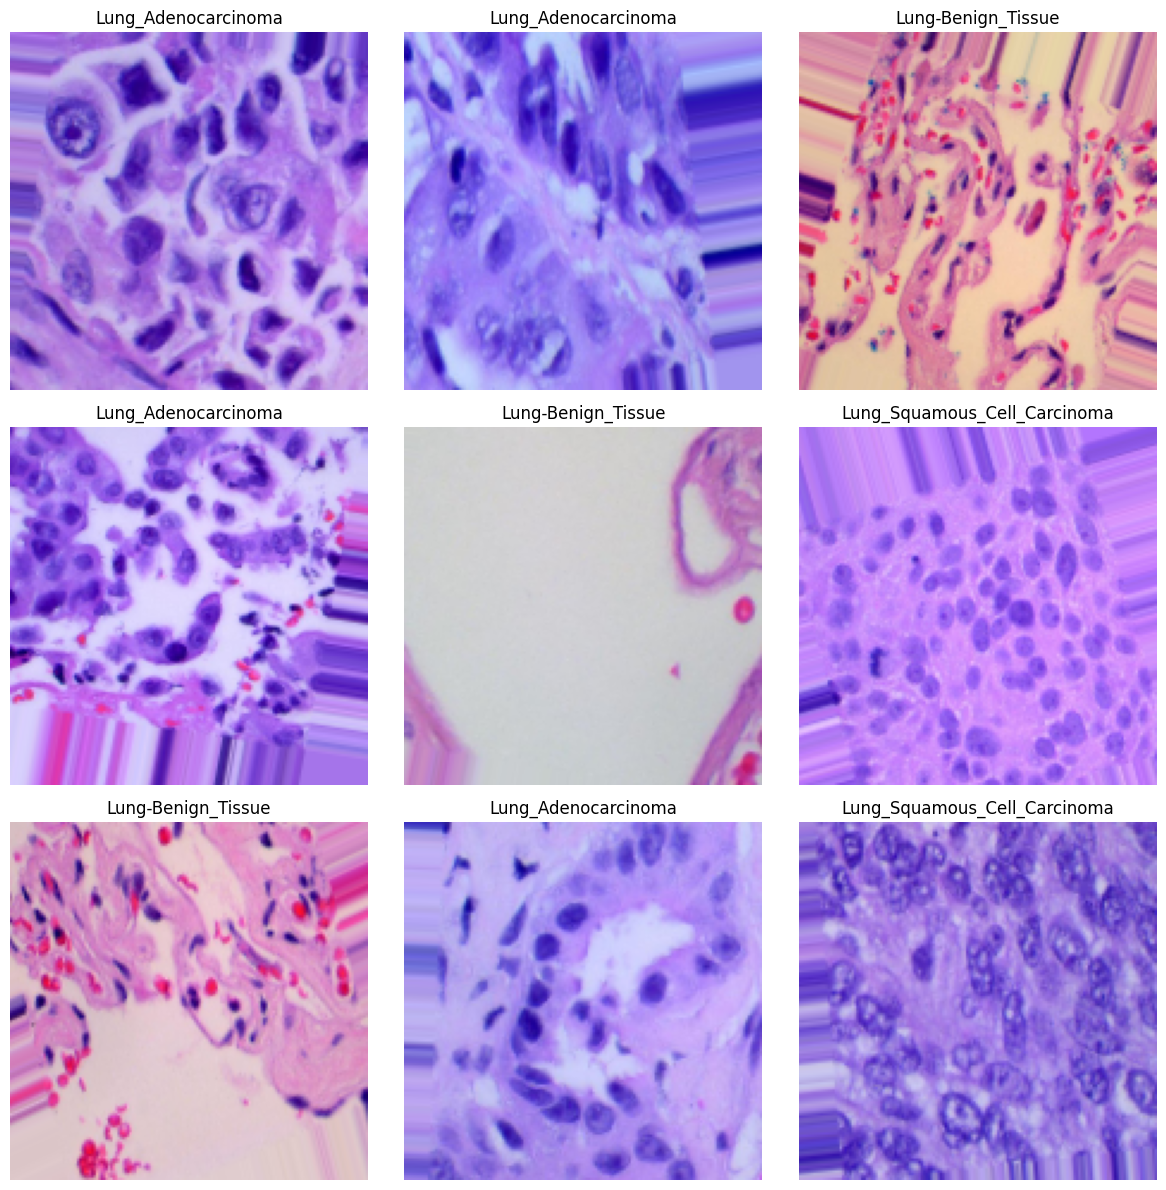

In [6]:
def visualize(generator):
    images, labels = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(12, 12))
    
    for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.title(class_names[np.argmax(labels[i])])  # Get the class name
        plt.imshow(images[i])
        plt.axis('off')  # Turn off axis labels for a cleaner look

    plt.tight_layout()
    plt.show()

# Visualize a batch from the training data
visualize(train_generator)

# Build model for Feature Extraction

In [7]:
import tensorflow as tf
import numpy as np
import os

def get_features_labels(generator, model, batch_size=32, save_path=None):
    X, y = [], []
    for i, (images, labels) in enumerate(generator):
        # Predict features using the hybrid model
        features = model.predict([images, images], verbose=0)
        
        X.append(features)
        y.append(labels)
        
        # Save intermediate results if save_path is provided
        if save_path:
            np.savez_compressed(f"{save_path}/batch_{i}.npz", X=features, y=labels)

        print(f"Processed batch {i+1}/{len(generator)}")
        
        if i + 1 == len(generator):
            break  # Stop after the final batch

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

# Using the hybrid model from the previous code
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights="imagenet", pooling="max")
efficientnet = tf.keras.applications.EfficientNetB0(input_shape=(150, 150, 3), include_top=False, weights="imagenet", pooling="max")

features_mobilenet = tf.keras.layers.Flatten()(mobilenet.output)
features_efficientnet = tf.keras.layers.Flatten()(efficientnet.output)

for model in [mobilenet, efficientnet]:
    for layer in model.layers:
        layer.trainable = False

output = tf.keras.layers.Concatenate()([features_mobilenet, features_efficientnet])

hybrid_model = tf.keras.Model(inputs=[mobilenet.input, efficientnet.input], outputs=output)
hybrid_model.summary()

/tmp/ipykernel_25/1611013628.py:28: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.

  mobilenet = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights="imagenet", pooling="max")



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 6,307,555 (24.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,307,555 (24.06 MB)

# Extract Features from Training Data

In [8]:
# Extract features and labels, saving batch-wise
save_path = "/kaggle/working/features"  # Change this path as needed
os.makedirs(save_path, exist_ok=True)

X_train, y_train = get_features_labels(train_generator, model=hybrid_model, save_path=save_path)

print(X_train.shape, y_train.shape)



I0000 00:00:1724182140.162960      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processed batch 1/329

Processed batch 2/329

Processed batch 3/329

Processed batch 4/329

Processed batch 5/329

Processed batch 6/329

Processed batch 7/329

Processed batch 8/329

Processed batch 9/329

Processed batch 10/329

Processed batch 11/329

Processed batch 12/329

Processed batch 13/329

Processed batch 14/329

Processed batch 15/329

Processed batch 16/329

Processed batch 17/329

Processed batch 18/329

Processed batch 19/329

Processed batch 20/329

Processed batch 21/329

Processed batch 22/329

Processed batch 23/329

Processed batch 24/329

Processed batch 25/329

Processed batch 26/329

Processed batch 27/329

Processed batch 28/329

Processed batch 29/329

Processed batch 30/329

Processed batch 31/329

Processed batch 32/329

Processed batch 33/329

Processed batch 34/329

Processed batch 35/329

Processed batch 36/329

Processed batch 37/329

Processed batch 38/329

Processed batch 39/329

Processed batch 40/329

Processed batch 41/329

Processed batch 42/329

P

# Extract Features from testing Data

In [9]:
# Extract features and labels, saving batch-wise
save_path = "/kaggle/working/test_features"  # Change this path as needed
os.makedirs(save_path, exist_ok=True)

X_test, y_test = get_features_labels(test_generator, model=hybrid_model, save_path=save_path)

print(X_test.shape, y_test.shape)

Processed batch 1/71

Processed batch 2/71

Processed batch 3/71

Processed batch 4/71

Processed batch 5/71

Processed batch 6/71

Processed batch 7/71

Processed batch 8/71

Processed batch 9/71

Processed batch 10/71

Processed batch 11/71

Processed batch 12/71

Processed batch 13/71

Processed batch 14/71

Processed batch 15/71

Processed batch 16/71

Processed batch 17/71

Processed batch 18/71

Processed batch 19/71

Processed batch 20/71

Processed batch 21/71

Processed batch 22/71

Processed batch 23/71

Processed batch 24/71

Processed batch 25/71

Processed batch 26/71

Processed batch 27/71

Processed batch 28/71

Processed batch 29/71

Processed batch 30/71

Processed batch 31/71

Processed batch 32/71

Processed batch 33/71

Processed batch 34/71

Processed batch 35/71

Processed batch 36/71

Processed batch 37/71

Processed batch 38/71

Processed batch 39/71

Processed batch 40/71

Processed batch 41/71

Processed batch 42/71

Processed batch 43/71

Processed batch 44/7

# Extract Features from Validation Data

In [10]:
# Extract features and labels, saving batch-wise
save_path = "/kaggle/working/val_features"  # Change this path as needed
os.makedirs(save_path, exist_ok=True)

X_val, y_val = get_features_labels(val_generator, model=hybrid_model, save_path=save_path)

print(X_val.shape, y_val.shape)

Processed batch 1/71

Processed batch 2/71

Processed batch 3/71

Processed batch 4/71

Processed batch 5/71

Processed batch 6/71

Processed batch 7/71

Processed batch 8/71

Processed batch 9/71

Processed batch 10/71

Processed batch 11/71

Processed batch 12/71

Processed batch 13/71

Processed batch 14/71

Processed batch 15/71

Processed batch 16/71

Processed batch 17/71

Processed batch 18/71

Processed batch 19/71

Processed batch 20/71

Processed batch 21/71

Processed batch 22/71

Processed batch 23/71

Processed batch 24/71

Processed batch 25/71

Processed batch 26/71

Processed batch 27/71

Processed batch 28/71

Processed batch 29/71

Processed batch 30/71

Processed batch 31/71

Processed batch 32/71

Processed batch 33/71

Processed batch 34/71

Processed batch 35/71

Processed batch 36/71

Processed batch 37/71

Processed batch 38/71

Processed batch 39/71

Processed batch 40/71

Processed batch 41/71

Processed batch 42/71

Processed batch 43/71

Processed batch 44/7

# Model Training

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Choose ResNet50 as the base model
base_model = tf.keras.applications.ResNet50(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for classification
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use a learning rate scheduler and early stopping
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator,
                    callbacks=[early_stopping, lr_scheduler])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

  self._warn_if_super_not_called()


  1/329 ━━━━━━━━━━━━━━━━━━━━ 6:34:05 72s/step - accuracy: 0.1875 - loss: 1.8783

W0000 00:00:1724182416.078484      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


232/329 ━━━━━━━━━━━━━━━━━━━━ 37s 386ms/step - accuracy: 0.8618 - loss: 0.3304

W0000 00:00:1724182505.278980      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8837 - loss: 0.2801

W0000 00:00:1724182533.886170      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1724182555.323337      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 212s 425ms/step - accuracy: 0.8839 - loss: 0.2797 - val_accuracy: 0.3333 - val_loss: 15.1460 - learning_rate: 1.0000e-04

Epoch 2/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 101s 302ms/step - accuracy: 0.9768 - loss: 0.0691 - val_accuracy: 0.3484 - val_loss: 3.6138 - learning_rate: 1.0000e-04

Epoch 3/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 102s 303ms/step - accuracy: 0.9862 - loss: 0.0391 - val_accuracy: 0.7138 - val_loss: 0.7662 - learning_rate: 1.0000e-04

Epoch 4/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 102s 304ms/step - accuracy: 0.9900 - loss: 0.0324 - val_accuracy: 0.9938 - val_loss: 0.0176 - learning_rate: 1.0000e-04

Epoch 5/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 102s 304ms/step - accuracy: 0.9878 - loss: 0.0371 - val_accuracy: 0.9960 - val_loss: 0.0113 - learning_rate: 1.0000e-04

Epoch 6/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 102s 305ms/step - accuracy: 0.9884 - loss: 0.0436 - val_accuracy: 0.9956 - val_loss: 0.0130 - learning_rate: 1.0000e-04

Epoch 7/50

329/329 ━━━━━━━━━━━━━━━━━━━

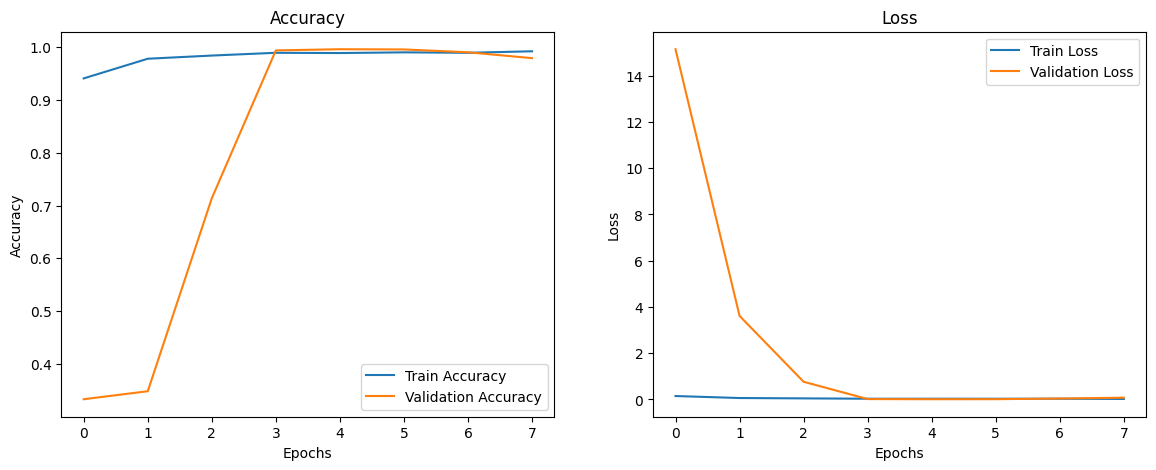

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_performance(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the performance curves
plot_performance(history)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Choose a more advanced base model, like EfficientNetB3 or ResNet50
base_model = tf.keras.applications.EfficientNetB3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for classification
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use a learning rate scheduler and early stopping
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator,
                    callbacks=[early_stopping, lr_scheduler])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Epoch 1/50

  1/329 ━━━━━━━━━━━━━━━━━━━━ 14:23:47 158s/step - accuracy: 0.3438 - loss: 1.1834

W0000 00:00:1724183433.205406      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/329 ━━━━━━━━━━━━━━━━━━━━ 11:48 2s/step - accuracy: 0.5694 - loss: 0.9025  

W0000 00:00:1724183531.733723      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8223 - loss: 0.4270

W0000 00:00:1724183613.594395      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1724183639.122996      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 364s 629ms/step - accuracy: 0.8226 - loss: 0.4264 - val_accuracy: 0.3333 - val_loss: 1.8232 - learning_rate: 1.0000e-04

Epoch 2/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 296ms/step - accuracy: 0.9695 - loss: 0.0868 - val_accuracy: 0.3600 - val_loss: 2.5738 - learning_rate: 1.0000e-04

Epoch 3/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 294ms/step - accuracy: 0.9825 - loss: 0.0477 - val_accuracy: 0.9542 - val_loss: 0.1014 - learning_rate: 1.0000e-04

Epoch 4/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.9893 - loss: 0.0321 - val_accuracy: 0.9960 - val_loss: 0.0094 - learning_rate: 1.0000e-04

Epoch 5/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 98s 292ms/step - accuracy: 0.9928 - loss: 0.0210 - val_accuracy: 0.9969 - val_loss: 0.0060 - learning_rate: 1.0000e-04

Epoch 6/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 98s 292ms/step - accuracy: 0.9944 - loss: 0.0173 - val_accuracy: 0.9982 - val_loss: 0.0057 - learning_rate: 1.0000e-04

Epoch 7/50

329/329 ━━━━━━━━━━━━━━━━━━━━ 100s

# Evaluate the Model on Test Data

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss*100}")
print(f"Test Accuracy: {test_accuracy*100}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 1.0000 - loss: 2.6233e-04

Test Loss: 0.09377035312354565

Test Accuracy: 99.95555281639099


In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_nms = ['LACA', 'LN', 'LSCC']
# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_nms))


 1/71 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step

W0000 00:00:1724184970.324744      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step

Classification Report:

              precision    recall  f1-score   support



        LACA       1.00      1.00      1.00       750

          LN       1.00      1.00      1.00       750

        LSCC       1.00      1.00      1.00       750



    accuracy                           1.00      2250

   macro avg       1.00      1.00      1.00      2250

weighted avg       1.00      1.00      1.00      2250




W0000 00:00:1724184996.850698      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


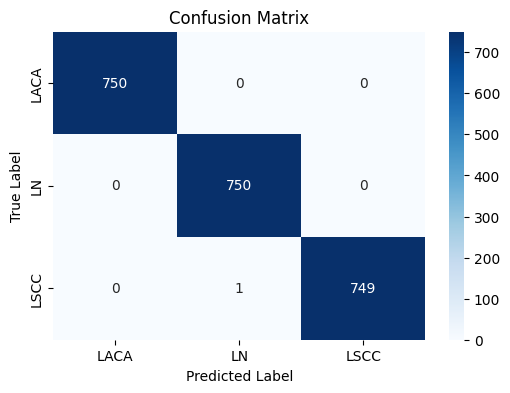

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_nms, yticklabels=class_nms)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Display Predictions with true Lables

71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step


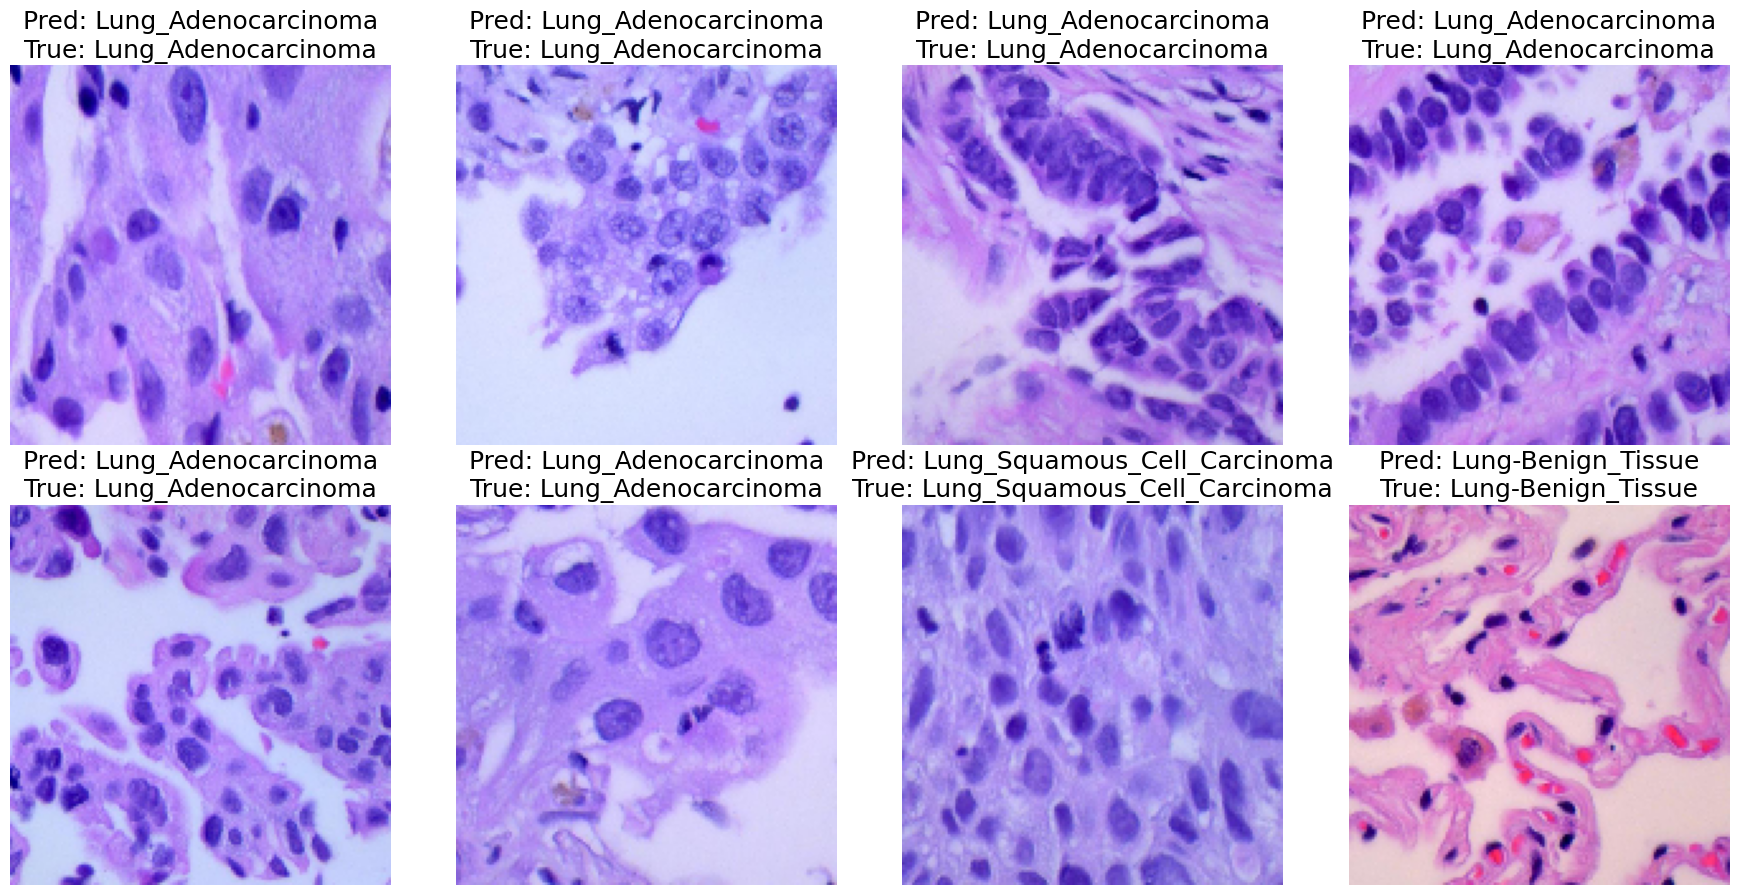

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

# Predict on the entire test dataset
predictions = model.predict(test_generator)
# Convert the predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
# Get the true class labels from the generator
true_classes = test_generator.classes
# Get the class labels
class_labels = list(test_generator.class_indices.keys())
# Get the file paths for the test images
file_paths = test_generator.filepaths


# Randomly select a few indices to display
random_indices = random.sample(range(len(file_paths)), 8)

plt.figure(figsize=(18, 9))  # Increase the figure size for better visibility

for i, idx in enumerate(random_indices):
    # Load the image
    img_path = file_paths[idx]
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    
    # Get the predicted and true labels
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    
    # Plot the image with the predicted and true labels
    plt.subplot(2, 4, i + 1)  # Use 2 rows and 4 columns for 8 images
    plt.imshow(img_array / 255.0)
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}', fontsize=18)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [18]:
# Saving the model
import tensorflow as tf

# Reloading the saved model
model = tf.keras.models.load_model('/kaggle/input/lung_cancer/keras/default/1/lung_cancer_model.h5')

# Image Resource

https://images.app.goo.gl/mYYbQkVN8fLAyDm19

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to predict
img_path = '/kaggle/input/lunglscc/lscc.jpg'  # Update this path to your image
true_class_label = 'Lung_Squamous_Cell_Carcinoma'  # Replace with the true class label of the image if known

# Load the image with the same target size as used during training (150x150)
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input shape of the model (1, 150, 150, 3)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image by 1./255 to match the preprocessing done during training
img_array = img_array / 255.0


In [20]:
# Make a prediction using the model
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Convert the predicted index to the corresponding class name
predicted_class = class_names[predicted_class_index]

# Print the prediction
print(f'The model predicts that this image is: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

The model predicts that this image is: Lung_Squamous_Cell_Carcinoma


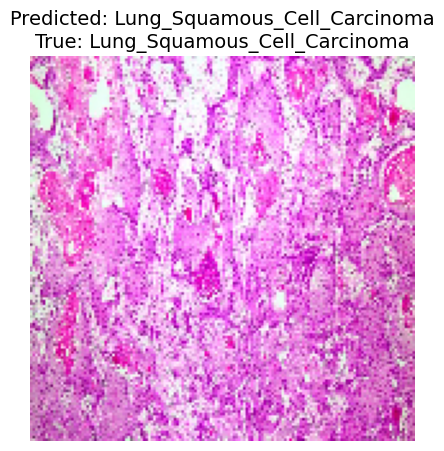

In [21]:
# Display the image with predicted and true labels
plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])
plt.title(f'Predicted: {predicted_class}\nTrue: {true_class_label}', fontsize=14)
plt.axis('off')
plt.show()